In [1]:
import os
import sys
import site
from peft import PeftModel, PeftConfig
from transformers import PaliGemmaProcessor, AutoModelForPreTraining
from huggingface_hub import login
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt

In [2]:
os.system(f"{sys.executable} -m pip install huggingface-hub Pillow")

0

In [3]:
python_version = f"{sys.version_info.major}.{sys.version_info.minor}"
site_packages_path = os.path.expanduser(f'~/.local/lib/python{python_version}/site-packages')
site.addsitedir(site_packages_path)

In [4]:
from huggingface_hub import notebook_login

notebook_login()

# Inference in multiple images

Encapsulei o codigo para utilizar uma função que faz a inferência em mais de uma imagem

In [6]:
def infer_images_with_questions(img_urls, questions, model_id="vannynakamura/paligemma_vqav2", base_model_id="google/paligemma-3b-pt-224"):
    # O número de perguntas e imagens deve ser igual
    if len(img_urls) != len(questions):
        raise ValueError("O número de URLs de imagens e perguntas deve ser igual.")

    # Carregar o PeftConfig e o modelo base
    config = PeftConfig.from_pretrained(model_id)
    base_model = AutoModelForPreTraining.from_pretrained(base_model_id)
    model = PeftModel.from_pretrained(base_model, model_id)
    processor = PaliGemmaProcessor.from_pretrained(base_model_id)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Processar cada imagem com sua pergunta correspondente
    for img_url, question in zip(img_urls, questions):
        input_image = Image.open(requests.get(img_url, stream=True).raw)
        input_text = "<image> <bos> " + question

        # Pré-processamento da entrada
        inputs = processor(
            text=input_text,
            images=input_image,
            padding="longest",
            do_convert_rgb=True,
            return_tensors="pt"
        ).to(device)

        inputs = inputs.to(dtype=model.dtype)

        # Inferência
        with torch.no_grad():
            output = model.generate(**inputs, max_length=496)
        decoded_output = processor.decode(output[0], skip_special_tokens=True)

        # Mostrar a imagem
        plt.figure(figsize=(6, 6))
        plt.imshow(input_image)
        plt.axis('off')
        plt.title(f"Pergunta: {question}\nResposta: {decoded_output.strip()}")
        plt.show()

In [7]:
# Lista de urls das imagens
img_urls = [
    "https://datasets-server.huggingface.co/assets/merve/vqav2-small/--/4b070c6254225a7355070c94e14c3275606f521d/--/default/validation/99/image/image.jpg?Expires=1732217493&Signature=kJmrlTHedinqllkBYLwzMaxNO0EaQkQIfHco79~0PJw3gd2zCR6sIoK959AsdM5HX60Hd3T9u-XSUXra-juGxf4Xj1sqnez5JJWCKs57FsESTmcgkz-1Ttef6uriaOOcOjg~pGD3ogFm1b5FV3aEhlMCyK075i4Ia3rrzt3vhWpW2H21DTffajzYJkiF~3Mel777xk~3N5fnrUjPIY9p8XUnlVhApmAycy4UaRZDzphcH3arIhiNqsHHBmOPWHqQ5abuwWsJqgmU-Sz4~J0IRSH1ZhzRx2Dgv-mNi-fR7cTraJDNTdp5QKmYUhE0qnJ5oduJzcDZzoTqfKsDBIOwQQ__&Key-Pair-Id=K3EI6M078Z3AC3",
    "https://datasets-server.huggingface.co/assets/merve/vqav2-small/--/4b070c6254225a7355070c94e14c3275606f521d/--/default/validation/58/image/image.jpg?Expires=1732217493&Signature=nk~5EIXDpctMHkLhx~-ICj~hw-ZP-D416dL-6vUURNkIztg~HJO9pbC1lG2aqvfcVPmbm4cbPCvMNjozGeBgG4~q~eLYiQaHhiYank3lLCNa6kNZ1N2DRET~gO3J4~c7lVgRsrsHyJuvGIxXweDqSGATnrRHB3Ca6ro28JMTiWBKfjbtANFLfbsyYCX0ALX3ou5hGDj-iEQo4kD05vdJODZIAmQd4~~IEBPHNrQtDbLvXQA9ysYKAqqxAheEePZJ3Cc0PvyVln0kWq57S7nExXfl2AhHxLalQQUvrPPbe6lMTMva4PPYWVpC~UaJFY8wS3uaclRu12GPSJSy~mgaAA__&Key-Pair-Id=K3EI6M078Z3AC3",
    "https://datasets-server.huggingface.co/assets/merve/vqav2-small/--/4b070c6254225a7355070c94e14c3275606f521d/--/default/validation/97/image/image.jpg?Expires=1732217493&Signature=ELPqJW2rt7-j32YF8CiIfTJEkInpU5xI4v4JAx2l-DsHH4YvLxHh6KRMbuk21fEwrUogi~6RIrpJVRB~ILiplkyg2bmqwe~HHrD4ogLKrjpfkAOqBjT3yyaGdMvULy3QmWut7PuduXhtnH-aa~BCtejmcKMg7-CBY-afUpqVduhs8ZPojy9EoUW7pqfAXIqrt7KDrKoaenxh99mK9qofQNvzZojsT52juSSWAlt82S4ekTQ0bB7Bg3H0wodB3rf~y3XshjyIXN38Iq9Tn6Z6bk9~-iV4~JUBHZlqGrwVI7A7MZgji~PtAb6l~0K7byhmAzqMBLAsDYbACqXpYcBtXQ__&Key-Pair-Id=K3EI6M078Z3AC3",
    "https://datasets-server.huggingface.co/assets/merve/vqav2-small/--/4b070c6254225a7355070c94e14c3275606f521d/--/default/validation/98/image/image.jpg?Expires=1732217493&Signature=egFgwpBiMGre-a5WRdqhH23MdhWiThIJuZ6KfOGLU3ZxsrE-7KKjonPzug76SQvx-azrLka-OkPwh0EDNBAB2YFJNZx6JxqnF3wwEo7TvaF25gWvkiHZnUQlo6PqpGFTJwmED22XksHEzZSmS37yWJWwfqDB5SKQpOSh6rAo2S6eQ54m9S3essolIN-Jy4Bl5s3FgDuAReLzw4LbTZufK2Ib9m93uCZGJwgaFVH1IVL7F2AWPF905PPt1F~KwD~kUaG20dSkwvreQCUfGAZFPbkCrczMU-QPUKGbHkJgSZ94fRDPeb8KTcItC-EdC~7ScwPj3hoytsEGtx7sgnurog__&Key-Pair-Id=K3EI6M078Z3AC3"
]

# Lista de perguntas para cada imagem
questions = [
    "How many people are present in the environment?",
    "Where is the person looking?",
    "What is in the image?",
    "Which device is in the image?"
]

model-00001-of-00003.safetensors:  76%|#######5  | 3.74G/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

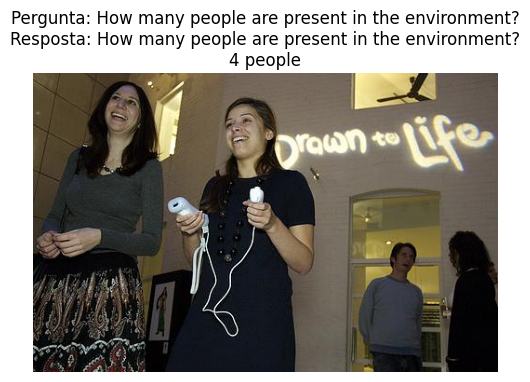

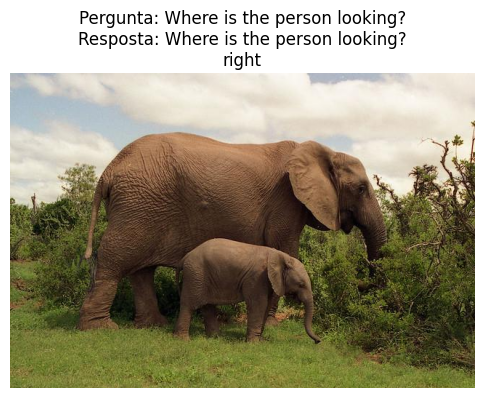

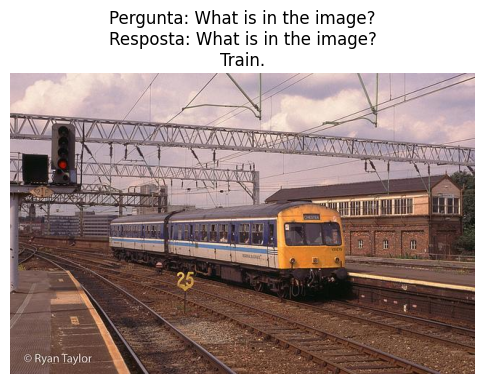

In [ ]:
# Função de inferência
infer_images_with_questions(img_urls, questions)